# Face Recognition

Face recognition problems commonly fall into two categories: 

- **Face Verification** - "is this the claimed person?". For example, at some airports, you can pass through customs by letting a system scan your passport and then verifying that you (the person carrying the passport) are the correct person. A mobile phone that unlocks using your face is also using face verification. This is a 1:1 matching problem. 
- **Face Recognition** - "who is this person?". For example, the video lecture showed a face recognition video (https://www.youtube.com/watch?v=wr4rx0Spihs) of Baidu employees entering the office without needing to otherwise identify themselves. This is a 1:K matching problem.

FaceNet learns a neural network that encodes a face image into a vector of 128 numbers. By comparing two such vectors, you can then determine if two pictures are of the same person.

We will be using a pre-trained model which represents ConvNet activations using a "channels first" convention, as opposed to the "channels last" convention used in lecture and previous programming assignments. In other words, a batch of images will be of shape $(m, n_C, n_H, n_W)$ instead of $(m, n_H, n_W, n_C)$. Both of these conventions have a reasonable amount of traction among open-source implementations; there isn't a uniform standard yet within the deep learning community.

First step is to load necessary packages.
Here we will use keras framework to build the model.

In [1]:
import sys
sys.path.insert(0,'../../homemade/face_recognition')
from keras.models import Sequential
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform
from keras.engine.topology import Layer
from keras import backend as K
K.set_image_data_format('channels_first')
import cv2
import os
import numpy as np
from numpy import genfromtxt
import pandas as pd
import tensorflow as tf
from fr_utils import *
from inception_blocks_v2 import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

np.set_printoptions(threshold=np.nan)

Using TensorFlow backend.


## Encoding face images into a 128-dimensional vector 

### Using an ConvNet  to compute encodings

The FaceNet model takes a lot of data and a long time to train. So following common practice is applied deep learning settings, let's just load weights that someone else has already trained. The network architecture follows the Inception model from [Szegedy *et al.*](https://arxiv.org/abs/1409.4842). We have provided an inception network implementation. You can look in the file `inception_blocks.py` to see how it is implemented  

The key things you need to know are:

- This network uses 96x96 dimensional RGB images as its input. Specifically, inputs a face image (or batch of $m$ face images) as a tensor of shape $(m, n_C, n_H, n_W) = (m, 3, 96, 96)$ 
- It outputs a matrix of shape $(m, 128)$ that encodes each input face image into a 128-dimensional vector

Run the cell below to create the model for face images.

In [2]:
FRmodel = faceRecoModel(input_shape=(3, 96, 96))
print("Total Params:", FRmodel.count_params())

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
dim is deprecated, use axis instead
Total Params: 3743280


### The Triplet Loss

For an image $x$, we denote its encoding $f(x)$, where $f$ is the function computed by the neural network.

<img src="../../images/face_recognition/f_x.png" style="width:380px;height:150px;">

<!--
We will also add a normalization step at the end of our model so that $\mid \mid f(x) \mid \mid_2 = 1$ (means the vector of encoding should be of norm 1).
!-->

Training will use triplets of images $(A, P, N)$:  

- A is an "Anchor" image--a picture of a person. 
- P is a "Positive" image--a picture of the same person as the Anchor image.
- N is a "Negative" image--a picture of a different person than the Anchor image.

These triplets are picked from our training dataset. We will write $(A^{(i)}, P^{(i)}, N^{(i)})$ to denote the $i$-th training example. 

You'd like to make sure that an image $A^{(i)}$ of an individual is closer to the Positive $P^{(i)}$ than to the Negative image $N^{(i)}$) by at least a margin $\alpha$:

$$\mid \mid f(A^{(i)}) - f(P^{(i)}) \mid \mid_2^2 + \alpha < \mid \mid f(A^{(i)}) - f(N^{(i)}) \mid \mid_2^2$$

You would thus like to minimize the following "triplet cost":

$$\mathcal{J} = \sum^{m}_{i=1} \large[ \small \underbrace{\mid \mid f(A^{(i)}) - f(P^{(i)}) \mid \mid_2^2}_\text{(1)} - \underbrace{\mid \mid f(A^{(i)}) - f(N^{(i)}) \mid \mid_2^2}_\text{(2)} + \alpha \large ] \small_+ \tag{3}$$

Here, we are using the notation "$[z]_+$" to denote $max(z,0)$.  

Notes:
- The term (1) is the squared distance between the anchor "A" and the positive "P" for a given triplet; you want this to be small. 
- The term (2) is the squared distance between the anchor "A" and the negative "N" for a given triplet, you want this to be relatively large, so it thus makes sense to have a minus sign preceding it. 
- $\alpha$ is called the margin. It is a hyperparameter that you should pick manually. We will use $\alpha = 0.2$. 

Most implementations also normalize the encoding vectors  to have norm equal one (i.e., $\mid \mid f(img)\mid \mid_2$=1); you won't have to worry about that here.


In [3]:
def triplet_loss(y_true, y_pred, alpha = 0.2):
    """
    Implementation of the triplet loss as defined by formula (3)
    
    Arguments:
    y_true -- true labels, required when you define a loss in Keras, you don't need it in this function.
    y_pred -- python list containing three objects:
            anchor -- the encodings for the anchor images, of shape (None, 128)
            positive -- the encodings for the positive images, of shape (None, 128)
            negative -- the encodings for the negative images, of shape (None, 128)
    
    Returns:
    loss -- real number, value of the loss
    """
    
    anchor, positive, negative = y_pred[0], y_pred[1], y_pred[2]
    
    # Step 1: Compute the (encoding) distance between the anchor and the positive, you will need to sum over axis=-1
    pos_dist = tf.reduce_sum(tf.square(tf.subtract(anchor,positive),),axis=None)
    
    # Step 2: Compute the (encoding) distance between the anchor and the negative, you will need to sum over axis=-1
    neg_dist = tf.reduce_sum(tf.square(tf.subtract(anchor, negative),),axis=None)
    
    # Step 3: subtract the two previous distances and add alpha.
    basic_loss = pos_dist - neg_dist + alpha
    
    # Step 4: Take the maximum of basic_loss and 0.0. Sum over the training examples.
    loss = tf.reduce_sum(tf.maximum(basic_loss,0.0))
    
    return loss


## Loading the trained model

FaceNet is trained by minimizing the triplet loss. But since training requires a lot of data and a lot of computation, we won't train it from scratch here. Instead, we load a previously trained model. Load a model using the following cell; this might take a couple of minutes to run. 


In [4]:
FRmodel.compile(optimizer = 'adam', loss = triplet_loss, metrics = ['accuracy'])

load_weights_from_FaceNet(FRmodel)

Instructions for updating:
keep_dims is deprecated, use keepdims instead



### Face Verification

Let's build a database containing one encoding vector for each person which you want to store in DataBase. To generate the encoding we use `img_to_encoding(image_path, model)` which basically runs the forward propagation of the model on the specified image. 

Run the following code to build the database (represented as a python dictionary). This database maps each person's name to a 128-dimensional encoding of their face.


In [5]:
database = {}
database["danielle"] = img_to_encoding("../../images/face_recognition/danielle.png", FRmodel)
database["younes"] = img_to_encoding("../../images/face_recognition/younes.jpg", FRmodel)
database["tian"] = img_to_encoding("../../images/face_recognition/tian.jpg", FRmodel)
database["andrew"] = img_to_encoding("../../images/face_recognition/andrew.jpg", FRmodel)
database["kian"] = img_to_encoding("../../images/face_recognition/kian.jpg", FRmodel)
database["dan"] = img_to_encoding("../../images/face_recognition/dan.jpg", FRmodel)
database["sebastiano"] = img_to_encoding("../../images/face_recognition/sebastiano.jpg", FRmodel)
database["bertrand"] = img_to_encoding("../../images/face_recognition/bertrand.jpg", FRmodel)
database["kevin"] = img_to_encoding("../../images/face_recognition/kevin.jpg", FRmodel)
database["felix"] = img_to_encoding("../../images/face_recognition/felix.jpg", FRmodel)
database["benoit"] = img_to_encoding("../../images/face_recognition/benoit.jpg", FRmodel)
database["arnaud"] = img_to_encoding("../../images/face_recognition/arnaud.jpg", FRmodel)
database["ashu"] = img_to_encoding("../../images/face_recognition/ashu_test.jpg",FRmodel)


## Verifying the Faces

Implementing the verify() function which checks if the camera picture (`image_path`) is actually the person called "identity". You will have to go through the following steps:

1. Compute the encoding of the image from image_path
2. Compute the distance about this encoding and the encoding of the identity image stored in the database
3. Open the door if the distance is less than 0.7, else do not open.


In [6]:
def verify(image_path, identity, database, model):
    """
    Function that verifies if the person on the "image_path" image is "identity".
    
    Arguments:
    image_path -- path to an image
    identity -- string, name of the person you'd like to verify the identity. Has to be a resident of the Happy house.
    database -- python dictionary mapping names of allowed people's names (strings) to their encodings (vectors).
    model -- your Inception model instance in Keras
    
    Returns:
    dist -- distance between the image_path and the image of "identity" in the database.
    door_open -- True, if the door should open. False otherwise.
    """
    
    # Step 1: Compute the encoding for the image. Use img_to_encoding() see example above. (≈ 1 line)
    encoding = img_to_encoding(image_path,model)
    
    # Step 2: Compute distance with identity's image (≈ 1 line)
    dist = np.linalg.norm(encoding-database[identity])
    
    plt.imshow(cv2.imread(image_path))
    plt.show()
    
    # Step 3: Open the door if dist < 0.7, else don't open (≈ 3 lines)
    if dist < 0.7:
        print("It's " + str(identity))
        door_open = True
    else:
        print("It's not " + str(identity))
        door_open = False
        
    return dist, door_open


Younes is trying to verify his image and  takes a picture of him ("images/face_recognition/camera_0.jpg"). Let's run verification algorithm on this picture:

<img src="../../images/face_recognition/camera_0.jpg" style="width:100px;height:100px;">


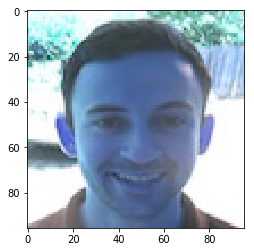

It's younes


(0.65939277, True)

In [7]:
verify("../../images/face_recognition/camera_0.jpg", "younes", database, FRmodel)


Bertrand is trying to verify his image and  takes a picture of him ("images/face_recognition/camera_1.jpg"). Let's run verification algorithm on this picture:

<img src="../../images/face_recognition/camera_1.jpg" style="width:100px;height:100px;">


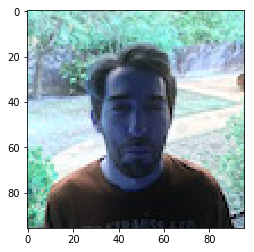

It's bertrand


(0.46768057, True)

In [8]:
verify("../../images/face_recognition/camera_1.jpg", "bertrand", database, FRmodel)


### Face Recognition

Face verification system is mostly working well. But since everytime, we have to give the name of person for whom we are verifying. This is not a good Approach.

Therefore, we would like to change your face verification system to a face recognition system. This way, we don't have to give the name of person each time 

We have implemented a face recognition system that takes as input an image, and figures out if it is one of the persons existing in the database (and if so, who). Unlike the previous face verification system, we will no longer get a person's name as another input. 

1. Compute the target encoding of the image from image_path
2. Find the encoding from the database that has smallest distance with the target encoding. 
    - Initialize the `min_dist` variable to a large enough number (100). It will help you keep track of what is the closest encoding to the input's encoding.
    - Loop over the database dictionary's names and encodings. To loop use `for (name, db_enc) in database.items()`.
        - Compute L2 distance between the target "encoding" and the current "encoding" from the database.
        - If this distance is less than the min_dist, then set min_dist to dist, and identity to name.


In [9]:
def who_is_it(image_path, database, model):
    """
    Implements face recognition for the happy house by finding who is the person on the image_path image.
    
    Arguments:
    image_path -- path to an image
    database -- database containing image encodings along with the name of the person on the image
    model -- your Inception model instance in Keras
    
    Returns:
    min_dist -- the minimum distance between image_path encoding and the encodings from the database
    identity -- string, the name prediction for the person on image_path
    """
    ## Step 1: Compute the target "encoding" for the image. Use img_to_encoding() see example above. ## (≈ 1 line)
    encoding = img_to_encoding(image_path,model)
    
    ## Step 2: Find the closest encoding ##
    
    # Initialize "min_dist" to a large value, say 100 (≈1 line)
    min_dist = 100
    
    # Loop over the database dictionary's names and encodings.
    for (name, db_enc) in database.items():
        
        # Compute L2 distance between the target "encoding" and the current "emb" from the database. (≈ 1 line)
        dist =  np.linalg.norm(encoding-db_enc)

        # If this distance is less than the min_dist, then set min_dist to dist, and identity to name. (≈ 3 lines)
        if dist < min_dist:
            min_dist = dist
            identity = name
            
    plt.imshow(cv2.imread(image_path))
    plt.show()
    
    if min_dist > 0.7:
        print("Not in the database.")
    else:
        print ("it's " + str(identity) + ", the distance is " + str(min_dist))
        
    return min_dist, identity


Younes is giving his image to our algorithm and our algorithm is correctly predicting his name.


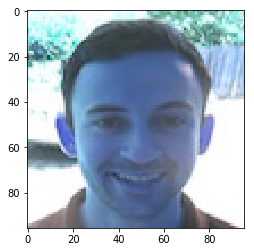

it's younes, the distance is 0.659393


(0.65939277, 'younes')

In [10]:
who_is_it("../../images/face_recognition/camera_0.jpg", database, FRmodel)


Benoit is giving his image to our algorithm and our algorithm is correctly predicting his name.


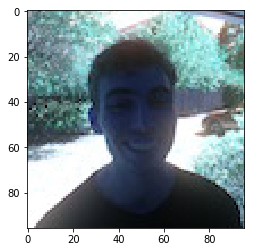

it's benoit, the distance is 0.231935


(0.23193513, 'benoit')

In [11]:
who_is_it("../../images/face_recognition/camera_2.jpg", database, FRmodel)


## Conceptuals from the Project : 

- Face verification solves an easier 1:1 matching problem; face recognition addresses a harder 1:K matching problem. 
- The triplet loss is an effective loss function for training a neural network to learn an encoding of a face image.
- The same encoding can be used for verification and recognition. Measuring distances between two images' encodings allows you to determine whether they are pictures of the same person. 



## References:

- Florian Schroff, Dmitry Kalenichenko, James Philbin (2015). [FaceNet: A Unified Embedding for Face Recognition and Clustering](https://arxiv.org/pdf/1503.03832.pdf)
- Yaniv Taigman, Ming Yang, Marc'Aurelio Ranzato, Lior Wolf (2014). [DeepFace: Closing the gap to human-level performance in face verification](https://research.fb.com/wp-content/uploads/2016/11/deepface-closing-the-gap-to-human-level-performance-in-face-verification.pdf) 
- The pretrained model we use is inspired by Victor Sy Wang's implementation and was loaded using his code: https://github.com/iwantooxxoox/Keras-OpenFace.
- Our implementation also took a lot of inspiration from the official FaceNet github repository: https://github.com/davidsandberg/facenet 
